In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Validate endogenous volumes against those from VP2030

In [3]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
sm = stepmodel.read_json(model_path + 'de_zones')

In [6]:
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
purposes = [s.split('_')[0] for s in sm.segments][::2]

In [7]:
# Load old volumes
volumes_file = 'de_volumes_exo'
v = stepmodel.read_zippedpickles(model_path + volumes_file)
# Rename columns from VP2030 to match the model's demand segments
car_segment_dict = {'0': '_no_car', '1': '_car'}
vp_purpose_dict = {'Fz1': 'commuting', 'Fz2': 'education', 'Fz3': 'buy/execute',
                   'Fz4': 'business', 'Fz6': 'leisure'}
sm.volumes = v.volumes.rename(columns={
    c: vp_purpose_dict[c.split('_')[0]]+car_segment_dict[c.split('_')[-1]]
    for c in v.volumes.columns if c.startswith('Fz')
})
# Create demand segment 'accompany' from 'Fz6' (private) with MiD2017 shares
accompany_no_car_share = 101 / 1530
accompany_car_share = 5569 / 30292
sm.volumes['accompany'+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * accompany_no_car_share
sm.volumes['accompany'+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * accompany_car_share
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * (1-accompany_no_car_share)
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * (1-accompany_car_share)

volumes: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/it]


In [10]:
# Sum of old volumes (inter-zonal)
sm.volumes.loc[sm.volumes['origin']!=sm.volumes['destination'], segments].sum().sum() / 1e9

18.79584296741475

In [11]:
# Load endogenously generated volumes
new = stepmodel.read_zippedpickles(model_path + 'de_volumes')

volumes: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.27s/it]


In [12]:
# Sum of new volumes
vol_sum = new.volumes.loc[new.volumes['origin']!=new.volumes['destination']
                         ].set_index(['origin', 'destination']).sum(axis=1).rename('vol')
vol_sum.sum() / 1e9

14.219706214548326

In [13]:
# Difference in OD sets
od_new = set([(o,d) for o,d in zip(new.volumes['origin'], new.volumes['destination'])])
od_vol = set([(o,d) for o,d in zip(sm.volumes['origin'], sm.volumes['destination'])])
len(od_vol - od_new)

19944

In [16]:
len(od_vol)

4910656

In [14]:
# Load the calibration dataset for validation
mid2017 = pd.read_csv(input_path + 'transport_demand/calibration_inter-cellular_trips_MiD2017.csv')
# Replace LAU codes with NUTS IDs
assert str(mid2017.loc[0, 'origin']).startswith('DE')
# Rename modes and purposes
mode_dict_mid = {1: 'rail_short', 2: 'rail_long',
                 3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid2017['mode_model'] = mid2017['mode_model'].map(mode_dict_mid)
mid2017['purpose_model'] = mid2017['purpose_model'].apply(lambda s: s.split('_')[0])

In [15]:
# Load VP2030 data for validation
vp2017 = pd.read_csv(network_path + 'vp2017_validation_normalised.csv')
# Restrict to inter-cell traffic and cells of the model
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017 = vp2017.groupby(['origin', 'destination']).sum()
mode_dict_vp = {'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'OESPV': 'bus', 'non': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[-1], mode_dict_vp[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])
# Aggregate by purpose
vp2017 = vp2017.groupby('segment', axis=1).sum().rename(columns=vp_purpose_dict)
vp2017.reset_index(inplace=True)

In [27]:
# Load distances
distances = pd.read_csv(output_path + 'distances_centroids.csv')
'''island_dict = sm.zones.loc[['outer_1', 'outer_2'], 'NUTS_ID'].to_dict()
distances['o'] = distances['origin'].replace(island_dict).str[:5]
distances['d'] = distances['destination'].replace(island_dict).str[:5]
distances_agg = distances.groupby(['o', 'd']).agg({'length': 'mean'})
distances_agg.index.set_names(['origin', 'destination'], inplace=True)
distances = distances.drop(['o', 'd'], axis=1).set_index(['origin', 'destination'])'''
distances = distances.set_index(['origin', 'destination'])

## Validation

In [28]:
# Define distance classes
bins = [0, 10, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 300, 500, 1000]
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

In [29]:
# Assign distances to volumes
for df in [sm.volumes, new.volumes, vp2017, mid2017]:
    df['dist'] = df.set_index(['origin', 'destination']).index.map(distances.to_dict()['length'])
    df['bins'] = pd.cut(df['dist'], bins=bins, labels=labels)

In [30]:
# Sum up volumes of the model and VP2030
vol_df = pd.DataFrame()
vol_df['endo'] = new.volumes.groupby('bins').sum()[segments].sum(axis=1)
vol_df['exo'] = sm.volumes.groupby('bins').sum()[segments].sum(axis=1)

<AxesSubplot:xlabel='bins'>

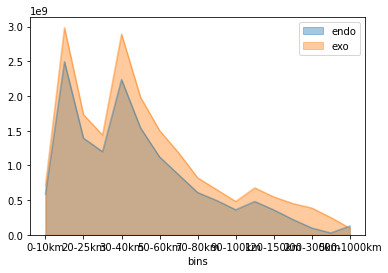

In [31]:
# plot
vol_df.plot(kind='area', stacked=False, alpha=.4,logx=False)

In [47]:
# Scale to VP2030 levels
vol_df['VP2030'] = vp2017.loc[vp2017['bins'].notna()].groupby('bins').sum()[
    ['commuting', 'education', 'buy/execute', 'business', 'leisure']
].sum(axis=1)
vol_df['endo'] /= vol_df['endo'].mean() / vol_df['VP2030'].mean()
vol_df['exo'] /= vol_df['exo'].mean() / vol_df['VP2030'].mean()

<AxesSubplot:xlabel='bins'>

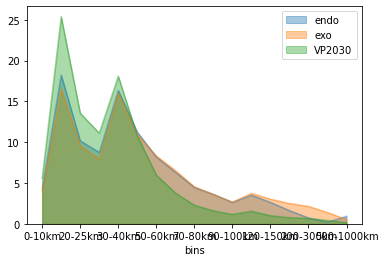

In [48]:
# plot with VP2030
vol_df.plot(kind='area', stacked=False, alpha=.4,logx=False)

In [49]:
# Add MiD2017
vol_df['MiD2017'] = mid2017.loc[mid2017['bins'].notna()].groupby('bins').size()
vol_df['MiD2017'] /= vol_df['MiD2017'].mean() / vol_df['VP2030'].mean()

<AxesSubplot:xlabel='bins'>

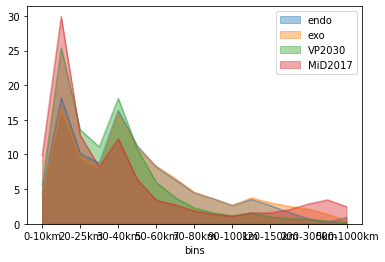

In [50]:
# plot all
vol_df.plot(kind='area', stacked=False, alpha=.4,logx=False)